# **Modeling and Evaluation**

## Objectives

* Business Requirement 2
    - The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs

* inputs/full_dataset/cherry-leaves/train
* inputs/full_dataset/cherry-leaves/validation
* inputs/full_dataset/cherry-leaves/test
* image shape embeddings

## Outputs

* Image distribution in each dataset ( train, validation and test)
* Image Augmentation
* Class indices to change prediction inference in labels
* Create and train machine learning (ML) model
* Save ML model
* Evaluate ML model 
* Check with a prediction on a random image file


## Additional Comments

* No additional comments



---

## Imports

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("whitegrid")
from matplotlib.image import imread

# Change working directory

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detector/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current, working directory

In [5]:
working_dir = os.getcwd()
working_dir

'/workspace/mildew-detector'

Set inputs

In [8]:
my_data_dir = 'inputs/full_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
validation_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Set outputs

In [9]:
version ='v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(working_dir) and version in os.listdir(working_dir + '/outputs'):
    print('Old ver is available. Create a new ver')
    pass
else:
    os.makedirs(name=file_path)

Old ver is available. Create a new ver


Set label name

In [10]:
labels = os.listdir(train_path)
print(f'Labels are: {labels}')

Labels are: ['healthy', 'powdery_mildew']


Set Image shape

In [11]:
version = 'v1'
img_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
img_shape

(256, 256, 3)

---

## Image count

---

* The number of images in each of the following datasets:
    - Train
    - Validation
    - Test
* Plot on a graph 
* Save plot


* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




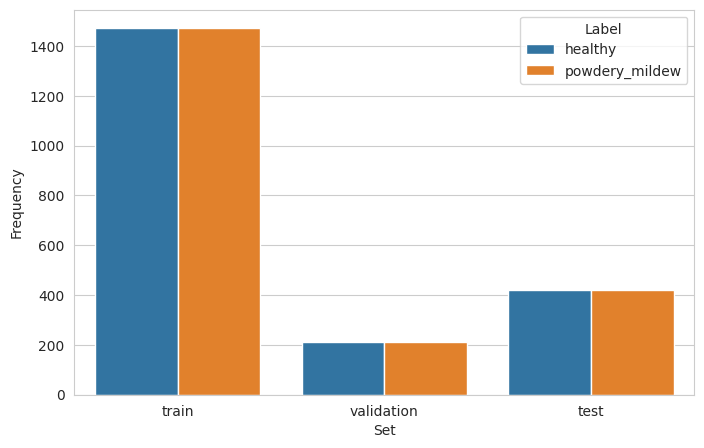

In [16]:
df_freq=pd.DataFrame([])
folders = ['train','validation', 'test']
for folder in folders:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(
                data = {
                    'Set':folder,
                    'Label':label,
                    'Frequency':int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
                }
            ),
            ignore_index=True
        )
        print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print('\n')
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x ='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

## Image Augmentation

* Generate Image Data

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
augment_img_data = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

* Augment train dataset

In [21]:
batch_size = 20
aug_train_set= augment_img_data.flow_from_directory(
    train_path,
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )
aug_train_set.class_indices


Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* Augment validation dataset

In [23]:
aug_validation_set= ImageDataGenerator(rescale=1./255).flow_from_directory(
    validation_path,
    target_size = img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

aug_validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* Augment test dataset

In [24]:
aug_test_set= ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size = img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

aug_test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Augmented Training Image 


* Plot augmented training image


(20, 256, 256, 3)


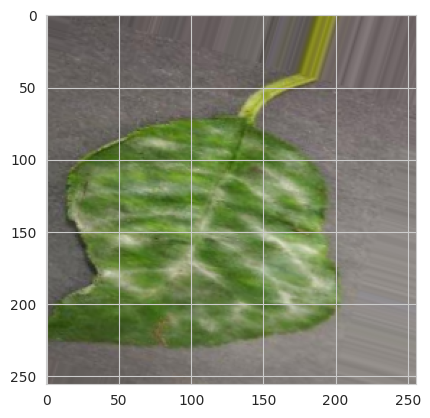

(20, 256, 256, 3)


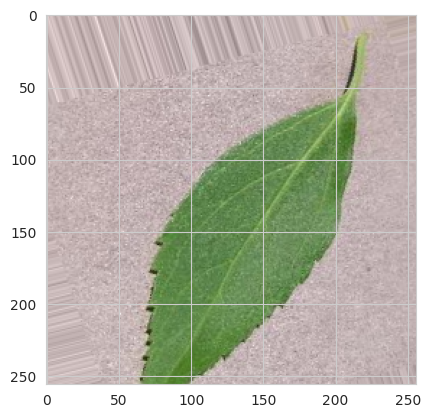

(20, 256, 256, 3)


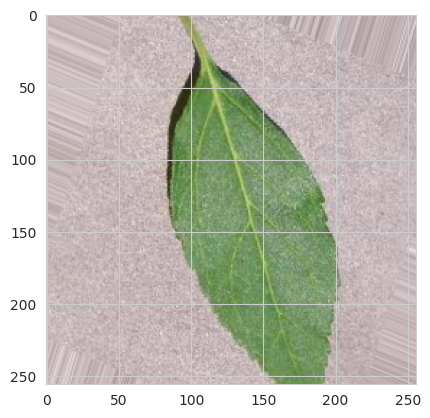

In [26]:
for _ in range(3):
    img,label = aug_train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

* Plot augmented validation images

(20, 256, 256, 3)


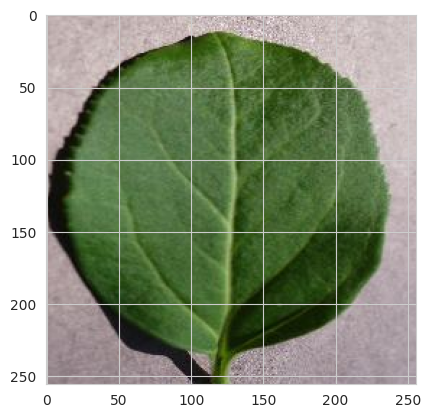

(20, 256, 256, 3)


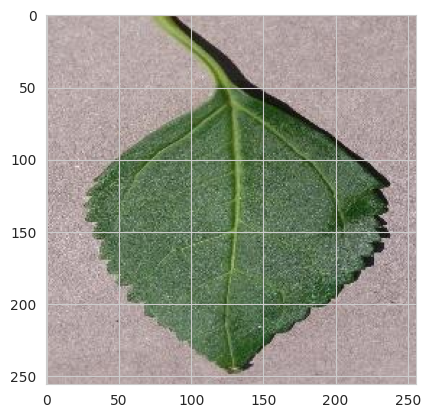

(20, 256, 256, 3)


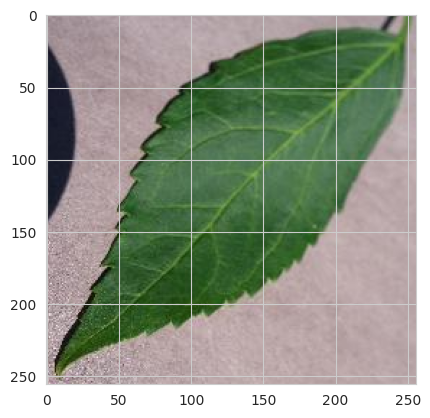

In [27]:
for _ in range(3):
    img,label = aug_validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

* Plot augmented test images

(20, 256, 256, 3)


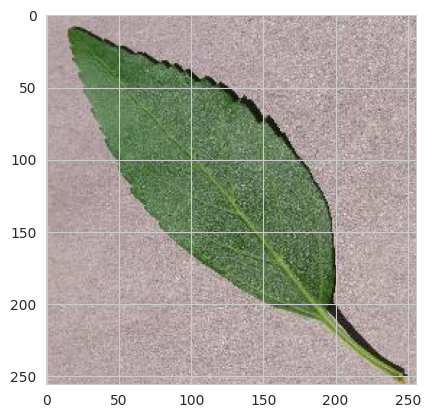

(20, 256, 256, 3)


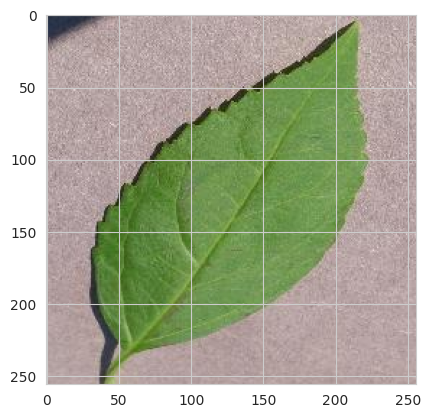

(20, 256, 256, 3)


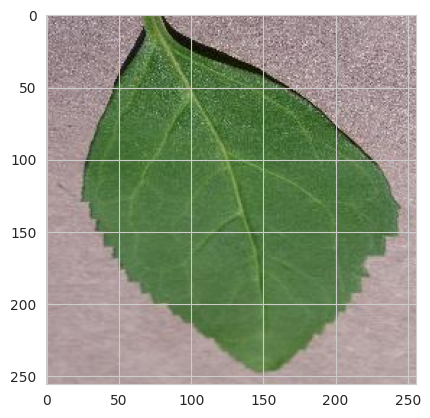

In [28]:
for _ in range(3):
    img,label = aug_test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

* Save class_indices

In [29]:
joblib.dump(
    value=aug_train_set.class_indices,
    filename=f'{file_path}/class_indices.pkl'
)

['outputs/v1/class_indices.pkl']

## Create ML Model

* Imports

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

* Model

In [47]:
def img_model_tf():
    """
    This function will create model with different layers,optimizeers and filters
    """
    model = Sequential()
    #input
    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=img_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=img_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=img_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    #output
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model


* Run model function

In [48]:
img_model_tf().summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 125, 125, 16)      4624      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 8)         1160      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 8)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7200)             

* Early Stop

In [49]:
early_stop=EarlyStopping(monitor='val_loss',patience=3)

## Fit ML Model for training

* Apply model to dataset

In [50]:
model = img_model_tf()
model.fit(
    aug_train_set,
    epochs=25,
    steps_per_epoch=len(aug_train_set.classes) // batch_size,
    validation_data=aug_validation_set,
    callbacks=[early_stop],
    verbose=1
)

2024-02-29 01:21:27.121747: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
147/147 [==============================] - 92s 617ms/step - loss: 1.9978 - accuracy: 0.0000e+00 - val_loss: 1.6128 - val_accuracy: 0.0000e+00
Epoch 2/25
147/147 [==============================] - 79s 533ms/step - loss: 1.3405 - accuracy: 0.1153 - val_loss: 1.2108 - val_accuracy: 0.3286
Epoch 3/25
147/147 [==============================] - 75s 507ms/step - loss: 1.3101 - accuracy: 0.1679 - val_loss: 1.5822 - val_accuracy: 0.0000e+00
Epoch 4/25
147/147 [==============================] - 74s 505ms/step - loss: 1.3781 - accuracy: 0.0298 - val_loss: 1.1749 - val_accuracy: 0.1476
Epoch 5/25
147/147 [==============================] - 74s 503ms/step - loss: 1.4480 - accuracy: 0.0636 - val_loss: 1.1923 - val_accuracy: 0.0881
Epoch 6/25
147/147 [==============================] - 73s 494ms/step - loss: 1.2212 - accuracy: 0.1276 - val_loss: 1.1938 - val_accuracy: 0.2857
Epoch 7/25
147/147 [==============================] - 74s 504ms/step - loss: 1.1685 - accuracy: 0.2281 - val_loss: 1.1

---

* Save the ML Model

In [52]:
model.save('outputs/v1/model/mildew_detector_model.h5')

## Model Performance

* Model learning curve

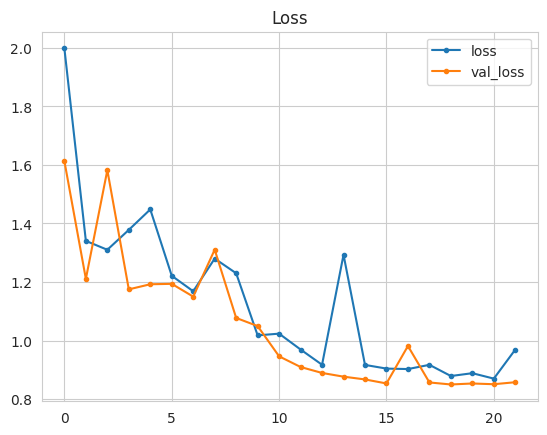

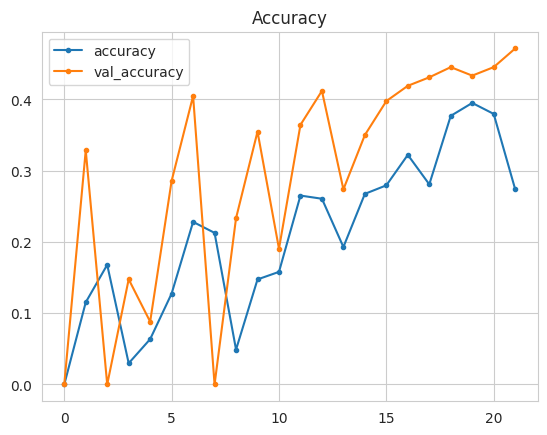

In [53]:
losses = pd.DataFrame(model.history.history)

sns.set_style('whitegrid')
losses[['loss', 'val_loss']].plot(style='.-')
plt.title('Loss')
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print('\n')
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title('Accuracy')
plt.savefig(f'{file_path}/model_training_accuracy.png', bbox_inches='tight', dpi=150)
plt.show()


* Model Evaluation
    - Load the saved ML model 
    - Evaluate the ML on the test set

In [55]:
from keras.models import load_model
model = load_model('outputs/v1/model/mildew_detector_model.h5')
evaluation=model.evaluate(aug_test_set)

 4/43 [=>............................] - ETA: 9s - loss: 0.0058 - accuracy: 0.8750

43/43 [==============================] - 11s 262ms/step - loss: 0.9251 - accuracy: 0.4668


* Save evaluation pkl

In [56]:
joblib.dump(
    value=evaluation,
    filename=f'outputs/v1/evaluation.pkl'
)

['outputs/v1/evaluation.pkl']

## Prediction on new images

* Load a random image

Shape: (256, 256), Mode: RGB


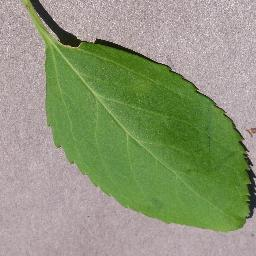

In [71]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0] 

img_pil = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/'+label)[pointer],
target_size=img_shape,color_mode='rgb')

print(f'Shape: {img_pil.size}, Mode: {img_pil.mode}')
img_pil

* Convert image to array

In [72]:
curr_test_img = image.img_to_array(img_pil)
curr_test_img = np.expand_dims(curr_test_img, axis=0)/255
print(curr_test_img.shape)

(1, 256, 256, 3)


## Probabilities

* Predict the class probabilities

In [73]:
pred_prob = model.predict(curr_test_img)[0,0]

target_map = {v: k for k, v in aug_train_set.class_indices.items()}
pred_class = target_map[pred_prob > 0.5]

if pred_class == target_map[0]: pred_prob = 1 - pred_prob

print(pred_prob)
print(pred_class)

1.0
healthy


## Conclusions

* Plot of distibution of images amongst sets
* Images Augmented in each set. 
* Class indices to change prediction inference in labels
* Created, train and saved machine learning (ML) model
* Evaluated ML model
* Checked with a prediction on a random image file with a high probability. 



---